# Trabalho Final - Detecção de Fraude em Pagamentos On-line
Disponível em https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset

## Objetivo
Os clientes desejam identificar e prevenir atividades fraudulentas em seu site para garantir uma experiência online segura e confiável para seus clientes. Portanto, desenvolver um sistema robusto e preciso que possa identificar e prevenir atividades fraudulentas em transações de pagamento online.

## Descrição do dataset
**Variable: Definition**

**step:** representa uma unidade de tempo onde 1 passo equivale a 1 hora

**type:** tipo de transação online

**amount:** o valor da transação

**nameOrig:** cliente iniciando a transação

**oldbalanceOrig:** saldo antes da transação

**newbalanceOrig:** saldo após a transação

**nameDest:** destinatário da transação

**oldbalanceDest:** saldo inicial do destinatário antes da transação

**newbalanceDest:** o novo saldo do destinatário após a transação

**isFraud:** transação fraudulenta

### Importando bibliotecas utilizadas

In [153]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

## import warnings
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=FutureWarning, module='sklearn')
warnings.filterwarnings(action='ignore', category=DataConversionWarning, module='sklearn')

### Importando Dataset

In [154]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Quantidade de tuplas e quantidade de espaço ocupado pelo dataset

In [155]:
num_tuplas = df.shape[0]
print(f"Número de tuplas: {num_tuplas}")
espaco_armazenamento = df.memory_usage().sum()
print(f"Espaço de armazenamento: {espaco_armazenamento/1000000} MB")

Número de tuplas: 6362620
Espaço de armazenamento: 559.910688 MB


## Análise dos dados
### Verificando se há dados NULL ou NaN

In [156]:
print("Dados nulos:")
print(df.isnull().sum())
print("Dados NaN:")
print(df.isna().sum())

Dados nulos:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
Dados NaN:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


### Verificando a coluna 'isFlaggedFraud'

In [157]:
df['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

### Excluindo colunas que não são necessárias

In [158]:
df.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1,inplace=True)
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


## Visualizando os dados
### Gráfico de contagem da coluna 'isFraud'

In [159]:
coluna = df['isFraud'].value_counts()
namesCol = colunaType.index
qtdCol = colunaType.values
px.pie(df,values=qtdCol,names=namesCol,hole=0.5,title="Distribuição das ocorrências de fraude")

### Gráfico de contagem da coluna 'type'

In [160]:
coluna = df['type'].value_counts()
namesCol = colunaType.index
qtdCol = colunaType.values
px.pie(df,values=qtdCol,names=namesCol,hole=0.5,title="Distribuição dos tipos de transações")

### Correlação com a coluna 'isFraud'

In [161]:
correlation = df.corr()
print(correlation['isFraud'].sort_values(ascending=False))

isFraud           1.000000
amount            0.076688
step              0.031578
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64


### Matriz de correlação

<AxesSubplot:>

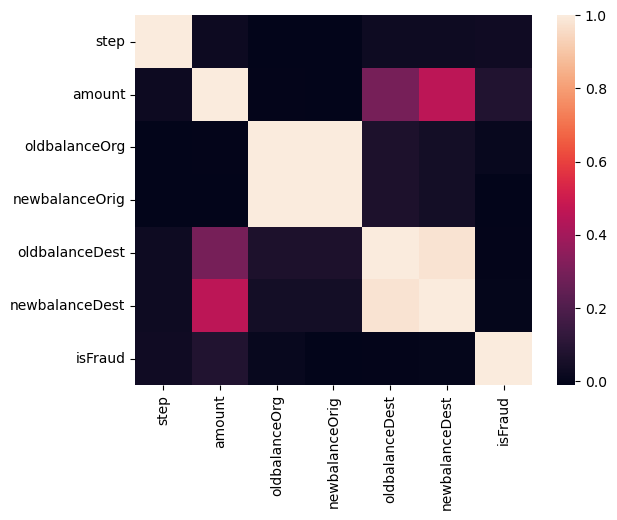

In [162]:
from seaborn import heatmap
heatmap(df.corr())

### Aplicando one-hot-encoder na coluna 'type'

In [163]:
df=pd.get_dummies(data=df,columns=['type'],drop_first=True)
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,1,0


## Treinando os modelos
### Separando os dados em features e target

In [164]:
X = df.drop('isFraud',axis=1)
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

## Utilizando o modelo Árvore de decisão
### Sem definir o hiperparâmetro max_depth

In [165]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train) # Training model
accuracy = model.score(X_test, y_test)
print(accuracy)

0.9997210268725777


### Com o hiperparâmetro max_depth igual a 3

In [166]:
model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train) # Training model
accuracy = model.score(X_test, y_test)
print(accuracy)

0.998961119790275


### Criando arquivo dot para vizualizar a arvore de decisão

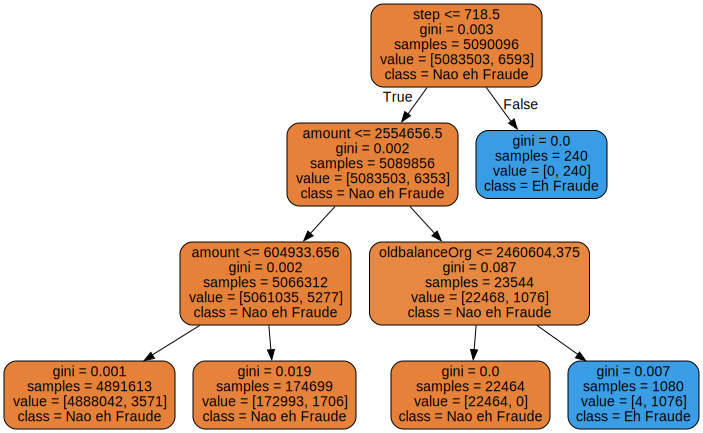

In [167]:
from sklearn import tree
import graphviz
nomes_colunas = X.columns.tolist()
tree.export_graphviz(model, out_file='DecisionTree.dot',
                   feature_names=nomes_colunas, 
                   class_names=['Nao eh Fraude', 'Eh Fraude'],
                   label='all',
                   rounded=True,
                   filled=True)
graph = graphviz.Source(open("DecisionTree.dot", "r").read())
graph

## Utilizando o modelo KNN
### Sem normalizar os dados

In [168]:
from sklearn import preprocessing, model_selection, neighbors
model = neighbors.KNeighborsClassifier(n_neighbors=3, metric='euclidean')
model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
print(accuracy)

0.999451483822702


### Normalizando os dados

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()

X_train_sc = sc_X.fit_transform(X_train)
X_test_sc = sc_X.transform(X_test)
model.fit(X_train_sc, y_train)
accuracy = model.score(X_test_sc, y_test)
print(accuracy)

## Utilizando o modelo rede neural - LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_train_sc = sc_X.fit_transform(X_train)
X_test_sc = sc_X.transform(X_test)
model = LogisticRegression(max_iter=1000)
model.fit(X_train_sc, y_train)
accuracy = model.score(X_test_sc, y_test)
print(accuracy)